<a href="https://colab.research.google.com/github/tumblingdice512/Research/blob/master/model5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Training log: 1 epoch (128 / 60000 train. data). Loss: 2.435809373855591
Training log: 1 epoch (1408 / 60000 train. data). Loss: 1.8232277631759644
Training log: 1 epoch (2688 / 60000 train. data). Loss: 1.375369668006897
Training log: 1 epoch (3968 / 60000 train. data). Loss: 1.2031720876693726
Training log: 1 epoch (5248 / 60000 train. data). Loss: 0.8374272584915161
Training log: 1 epoch (6528 / 60000 train. data). Loss: 0.7198622822761536
Training log: 1 epoch (7808 / 60000 train. data). Loss: 0.6596168875694275
Training log: 1 epoch (9088 / 60000 train. data). Loss: 0.5850553512573242
Training log: 1 epoch (10368 / 60000 train. data). Loss: 0.4894704818725586
Training log: 1 epoch (11648 / 60000 train. data). Loss: 0.5056400895118713
Training log: 1 epoch (12928 / 60000 train. data). Loss: 0.44230204820632935
Training log: 1 epoch (14208 / 60000 train. data). Loss: 0.44393062591552734
Training log: 1 epoch (15488 / 60000 train. data). Loss: 0.48126766085624695
Training log: 1 epoc

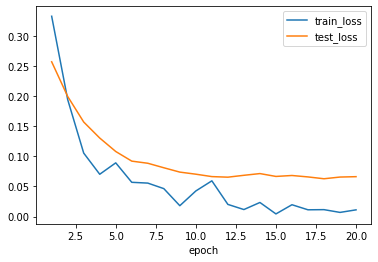

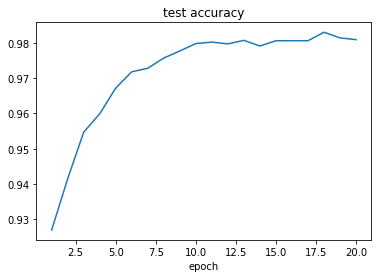

In [ ]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
 
 
class Network1(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 1000)
        self.fc2 = torch.nn.Linear(1000, 10)
 
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
 
        return f.log_softmax(x, dim=1)
 
 
def load_MNIST(batch=128, intensity=1.0):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=True,
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    return {'train': train_loader, 'test': test_loader}
 
 
if __name__ == '__main__':
    # 学習回数
    epoch = 20
 
    # 学習結果の保存用
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': [],
    }
 
    # ネットワークを構築
    net: torch.nn.Module = Network1()
 
    # MNISTのデータローダーを取得
    loaders = load_MNIST()
 
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
 
    for e in range(epoch):
 
        """ Training Part"""
        loss = None
        # 学習開始 (再開)
        net.train(True)  # 引数は省略可能
        for i, (data, target) in enumerate(loaders['train']):
            # 全結合のみのネットワークでは入力を1次元に
            # print(data.shape)  # torch.Size([128, 1, 28, 28])
            data = data.view(-1, 28*28)
            # print(data.shape)  # torch.Size([128, 784])
 
            optimizer.zero_grad()
            output = net(data)
            loss = f.nll_loss(output, target)
            loss.backward()
            optimizer.step()
 
            if i % 10 == 0:
                print('Training log: {} epoch ({} / 60000 train. data). Loss: {}'.format(e+1,
                                                                                         (i+1)*128,
                                                                                         loss.item())
                      )
 
        history['train_loss'].append(loss)
 
        """ Test Part """
        # 学習のストップ
        net.eval()  # または net.train(False) でも良い
        test_loss = 0
        correct = 0
 
        with torch.no_grad():
            for data, target in loaders['test']:
                data = data.view(-1, 28 * 28)
                output = net(data)
                test_loss += f.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
 
        test_loss /= 10000
 
        print('Test loss (avg): {}, Accuracy: {}'.format(test_loss,
                                                         correct / 10000))
 
        history['test_loss'].append(test_loss)
        history['test_acc'].append(correct / 10000)
 
    # 結果の出力と描画
    print(history)
    plt.figure()
    plt.plot(range(1, epoch+1), history['train_loss'], label='train_loss')
    plt.plot(range(1, epoch+1), history['test_loss'], label='test_loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig('loss.png')
 
    plt.figure()
    plt.plot(range(1, epoch+1), history['test_acc'])
    plt.title('test accuracy')
    plt.xlabel('epoch')
    plt.savefig('test_acc.png')